In [1]:
from sys import path
path.append('..')
path.append('../../src/')

import os
import cv2
import numpy as np
import pickle as pkl
import matplotlib.pyplot as plt
import mlflow
import mlflow.keras
import random as rn
import tensorflow as tf
from os.path import basename, join

from keras.models import Model, load_model
from keras.layers import Input, Dense, Dropout, BatchNormalization, Activation
from keras.layers import Conv2D, Conv2DTranspose, MaxPool2D, UpSampling2D, GlobalAvgPool2D
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils.vis_utils import plot_model

from skmultilearn.model_selection import iterative_train_test_split

from tensorflow.contrib.tensorboard.plugins import projector

from global_config import RANDOM_SEED, IMAGE_SIZE, FILE_DUMP_IMAGES, FILE_DUMP_MRKS
from local_config import FOLDER_MODELS, FILE_AUTOENCODER_SAMPLES
from custom_metrics import precision, recall, f1, specificity, fbeta
from custom_metrics import negative_predictive_value as npv 
from custom_metrics import matthews_correlation_coefficient as mcc
from utils import plot

%matplotlib inline

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\tensorflow\python\util\nest.py:823: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  _pywrap_tensorflow.RegisterType("Mapping", _collections.Mapping)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\tensorflow\python\training\checkpointable\data_structures.py:312: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  class _ListWrapper(List, collections.MutableSequence,
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\tensorflow\python\training\checkpointable\util.py:448: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  class _ObjectIdentitySet(collections.MutableSet):
Using Te

In [2]:
PATH_TO_ROOT = '../../'

FOLDER_LOGS = join(PATH_TO_ROOT, 'logs')
FOLDER_MODELS = join(PATH_TO_ROOT, FOLDER_MODELS)
FILE_DUMP_MRKS = join(PATH_TO_ROOT, FILE_DUMP_MRKS)
FILE_DUMP_IMAGES = join(PATH_TO_ROOT, FILE_DUMP_IMAGES)
FILE_AUTOENCODER_SAMPLES = join(PATH_TO_ROOT, FILE_AUTOENCODER_SAMPLES)

print(FOLDER_LOGS)
print(FOLDER_MODELS)
print(FILE_DUMP_MRKS)
print(FILE_DUMP_IMAGES)
print(FILE_AUTOENCODER_SAMPLES)

../../logs
../../models/unsupervised_supervised/
../../data/cropped_faces/cropped_faces_mrks.pkl
../../data/cropped_faces/cropped_faces_images.pkl
../../data/unsupervised_supervised_samples.pkl


In [3]:
TEST_SIZE = 0.1
MLFLOW_EXPERIMENT_NAME = 'Unsupervised + Supervised'

In [4]:
def timestamp_model_name(prefix='model_', suffix='', format='%Y_%m_%d-%H_%M_%S', ext='.h5'):
    from datetime import datetime
    timestamp = datetime.now().strftime(format)
    return f'{prefix}{timestamp}{suffix}{ext}'


def set_random_seeds():
    os.environ['PYTHONHASHSEED'] = str(RANDOM_SEED)
    rn.seed(RANDOM_SEED)
    np.random.seed(RANDOM_SEED)
    tf.set_random_seed(RANDOM_SEED)

# Data Loading 

In [5]:
x, _ = pkl.load(open(FILE_DUMP_IMAGES, 'rb'))
mrks, _ = pkl.load(open(FILE_DUMP_MRKS, 'rb'))
y = np.array([mrk_file.photo_reqs.values() for mrk_file in mrks])

print(x.shape, x.dtype)
print(y.shape, y.dtype)
print(len(mrks))

(5731, 160, 160, 3) float32
(5731, 23) int32
5731


In [6]:
np.random.seed(RANDOM_SEED)
x_train_idx, y_train, x_val_idx, y_val = iterative_train_test_split(np.arange(x.shape[0]).reshape(-1, 1), y, test_size=TEST_SIZE)
x_train_idx = x_train_idx.ravel()
x_val_idx = x_val_idx.ravel()

x_train = x[x_train_idx]
x_val = x[x_val_idx]

print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)

(5151, 160, 160, 3) (5151, 23)
(580, 160, 160, 3) (580, 23)


In [7]:
train_mrks = mrks[x_train_idx]
val_mrks = mrks[x_val_idx]

pkl.dump((x_train, x_val, train_mrks, val_mrks), open(FILE_AUTOENCODER_SAMPLES, 'wb'), -1)

# Model Training 

In [8]:
x_train, x_val, _, _ = pkl.load(open(FILE_AUTOENCODER_SAMPLES, 'rb'))
x_train /= 255.0
x_val /= 255.0

print(x_train.shape, x_train.dtype, x_train.min(), x_train.max())
print(x_val.shape, x_val.dtype, x_val.min(), x_val.max())

(5151, 160, 160, 3) float32 0.0 1.0
(580, 160, 160, 3) float32 0.0 1.0


In [9]:
def conv_bn(idx, prev_input, filters, activation='relu', name=None):
    conv_name = 'conv_' + str(idx)
    bn_name = 'bn_' + str(idx)
    act_name = f'{activation}_' + str(idx) if name is None else name
    
    conv = Conv2D(filters, kernel_size=(3, 3), strides=(1, 1), padding='same', activation=None, name=conv_name)(prev_input)
    conv = BatchNormalization(axis=-1, name=bn_name)(conv)
    conv = Activation(activation, name=act_name)(conv)
    return conv


def conv_bn_maxpool(idx, prev_input, filters):
    pool_name = 'pool_' + str(idx)
    
    conv = conv_bn(idx, prev_input, filters)
    pool = MaxPool2D(pool_size=(2, 2), strides=(2, 2), padding='valid', name=pool_name)(conv)
    return pool


def deconv_bn(idx, prev_input, filters, activation='relu'):
    bn_name = str(idx) + '_bn' 
    act_name = str(idx) + '_relu' 
    conv_name = str(idx) + '_conv' 
    
    deconv = Conv2DTranspose(filters, kernel_size=(3, 3), strides=(2, 2), padding='same', activation=None, name=conv_name)(prev_input)
    deconv = BatchNormalization(axis=-1, name=bn_name)(deconv)
    deconv = Activation(activation, name=act_name)(deconv)
    return deconv


def dense_layer(idx, prev_input, units, dropout=True, rate=0.5, activation='relu'):
    dense_name = f"dense_{idx}"
    drop_name = f"dropout_{idx}"
    
    out = Dense(units, activation=activation)(prev_input)
    if dropout:
        out = Dropout(rate)(out)
    return out

In [10]:
mlflow.set_experiment(MLFLOW_EXPERIMENT_NAME)
mlflow.log_param("test_size", TEST_SIZE)
mlflow.log_param("seed", RANDOM_SEED)
mlflow.keras.autolog()

set_random_seeds()
N_REQS = y_train.shape[1]

inputs = Input(shape=x_train.shape[1:], name='input')
pool_1 = conv_bn_maxpool(1, inputs, 32)
pool_2 = conv_bn_maxpool(2, pool_1, 64)
pool_3 = conv_bn_maxpool(3, pool_2, 128)
pool_4 = conv_bn_maxpool(4, pool_3, 256)
encode = conv_bn(5, pool_4, 256, activation='tanh', name='encoded')

dec_4 = deconv_bn(4, encode, 256)
dec_3 = deconv_bn(3, dec_4, 128)
dec_2 = deconv_bn(2, dec_3, 64)
dec_1 = deconv_bn(1, dec_2, 32)
decoded = Conv2D(filters=3, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='sigmoid', name='decoded')(dec_1)

avg_pool = GlobalAvgPool2D()(encode)
dense_1 = dense_layer(1, avg_pool, 64)
dense_2 = dense_layer(2, dense_1, 32, dropout=False)
classif = Dense(units=N_REQS, activation='sigmoid', name='outputs')(dense_2)

model = Model(inputs=inputs, outputs=[decoded, classif])
model.summary()

INFO: 'Unsupervised + Supervised' does not exist. Creating a new experiment
Instructions for updating:
Colocations handled automatically by placer.


C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 160, 160, 3)  0                                            
__________________________________________________________________________________________________
conv_1 (Conv2D)                 (None, 160, 160, 32) 896         input[0][0]                      
__________________________________________________________________________________________________
bn_1 (BatchNormalization)       (None, 160, 160, 32) 128         conv_1[0][0]                     
__________________________________________________________________________________________________
relu_1 (Activation)             (None, 160, 160, 32) 0           bn_1[0][0]                       
____________________________________________________________________________________________

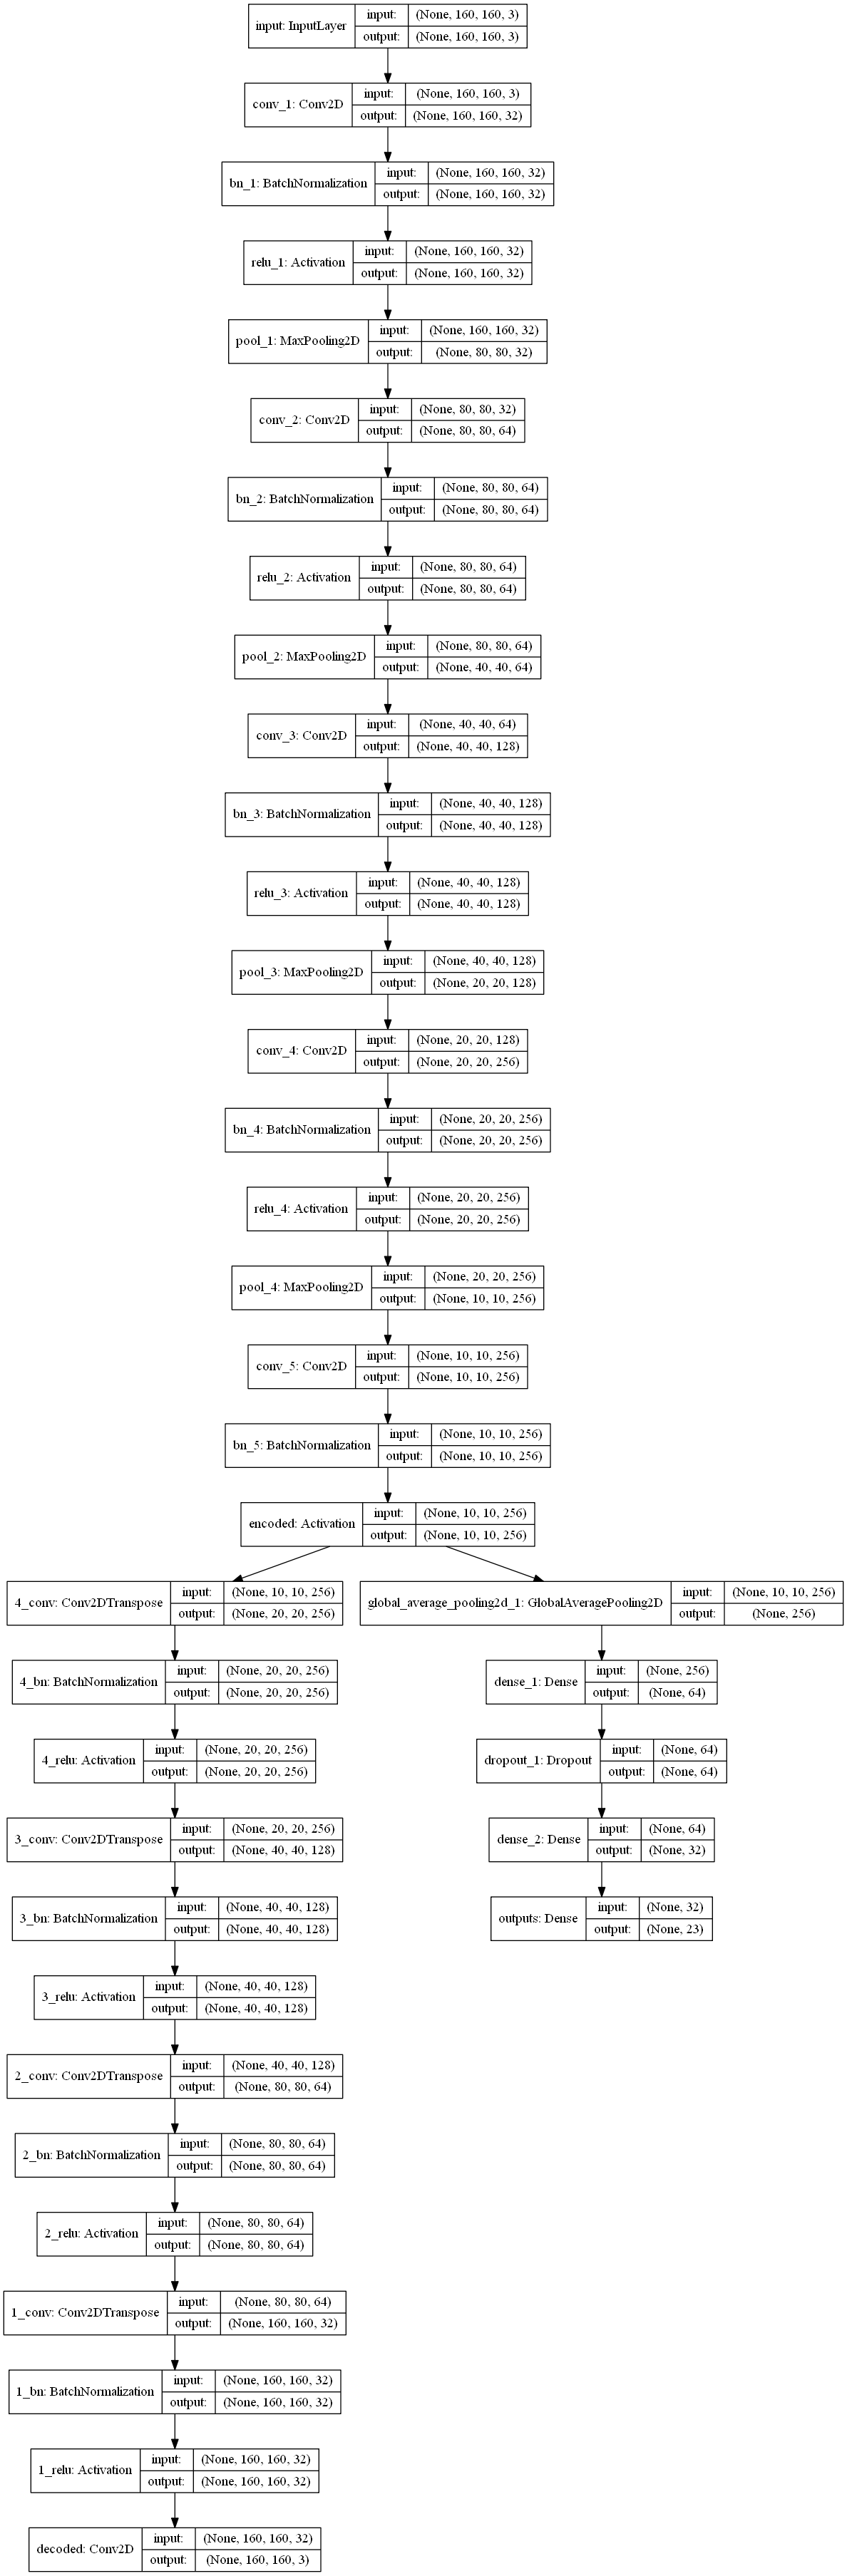

In [11]:
plot_model(model, show_shapes=True)

Instructions for updating:
Use tf.cast instead.


C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 5151 samples, validate on 580 samples
Epoch 1/100
5151/5151 [==============================] - 59s 11ms/step - loss: 0.2412 - decoded_loss: 0.0204 - outputs_loss: 0.4621 - outputs_accuracy: 0.7790 - outputs_precision: 0.8376 - outputs_recall: 0.8978 - outputs_f1: 0.8643 - outputs_fbeta: 0.8811 - outputs_specificity: 0.3100 - outputs_negative_predictive_value: 0.4779 - outputs_matthews_correlation_coefficient: 0.2538 - val_loss: 0.3103 - val_decoded_loss: 0.0929 - val_outputs_loss: 0.5407 - val_outputs_accuracy: 0.7762 - val_outputs_precision: 0.7766 - val_outputs_recall: 0.9838 - val_outputs_f1: 0.8664 - val_outputs_fbeta: 0.9292 - val_outputs_specificity: 0.0069 - val_outputs_negative_predictive_value: 0.0867 - val_outputs_matthews_correlation_coefficient: -0.0277

Epoch 00001: val_outputs_matthews_correlation_coefficient improved from -inf to -0.02765, saving model to ../../models/unsupervised_supervised/multilearner_2020_07_04-20_23_52.h5
Epoch 2/100
5151/5151 [============

5151/5151 [==============================] - 53s 10ms/step - loss: 0.1475 - decoded_loss: 0.0066 - outputs_loss: 0.2884 - outputs_accuracy: 0.8743 - outputs_precision: 0.8911 - outputs_recall: 0.9599 - outputs_f1: 0.9241 - outputs_fbeta: 0.9428 - outputs_specificity: 0.5338 - outputs_negative_predictive_value: 0.7688 - outputs_matthews_correlation_coefficient: 0.5703 - val_loss: 0.1043 - val_decoded_loss: 0.0088 - val_outputs_loss: 0.2081 - val_outputs_accuracy: 0.9188 - val_outputs_precision: 0.9217 - val_outputs_recall: 0.9697 - val_outputs_f1: 0.9441 - val_outputs_fbeta: 0.9588 - val_outputs_specificity: 0.7378 - val_outputs_negative_predictive_value: 0.8688 - val_outputs_matthews_correlation_coefficient: 0.7468

Epoch 00010: val_outputs_matthews_correlation_coefficient improved from 0.64853 to 0.74681, saving model to ../../models/unsupervised_supervised/multilearner_2020_07_04-20_23_52.h5
Epoch 11/100
5151/5151 [==============================] - 53s 10ms/step - loss: 0.1428 - deco


Epoch 00019: val_outputs_matthews_correlation_coefficient did not improve from 0.76648
Epoch 20/100
5151/5151 [==============================] - 53s 10ms/step - loss: 0.1235 - decoded_loss: 0.0053 - outputs_loss: 0.2418 - outputs_accuracy: 0.8951 - outputs_precision: 0.9087 - outputs_recall: 0.9657 - outputs_f1: 0.9363 - outputs_fbeta: 0.9515 - outputs_specificity: 0.6149 - outputs_negative_predictive_value: 0.8169 - outputs_matthews_correlation_coefficient: 0.6487 - val_loss: 0.1240 - val_decoded_loss: 0.0066 - val_outputs_loss: 0.2516 - val_outputs_accuracy: 0.9067 - val_outputs_precision: 0.9015 - val_outputs_recall: 0.9792 - val_outputs_f1: 0.9381 - val_outputs_fbeta: 0.9610 - val_outputs_specificity: 0.6416 - val_outputs_negative_predictive_value: 0.8980 - val_outputs_matthews_correlation_coefficient: 0.7038

Epoch 00020: val_outputs_matthews_correlation_coefficient did not improve from 0.76648
Epoch 21/100
5151/5151 [==============================] - 53s 10ms/step - loss: 0.1205


Epoch 00029: val_outputs_matthews_correlation_coefficient did not improve from 0.78921
Epoch 30/100
5151/5151 [==============================] - 53s 10ms/step - loss: 0.1059 - decoded_loss: 0.0047 - outputs_loss: 0.2071 - outputs_accuracy: 0.9137 - outputs_precision: 0.9255 - outputs_recall: 0.9699 - outputs_f1: 0.9471 - outputs_fbeta: 0.9587 - outputs_specificity: 0.6905 - outputs_negative_predictive_value: 0.8515 - outputs_matthews_correlation_coefficient: 0.7161 - val_loss: 0.1768 - val_decoded_loss: 0.0060 - val_outputs_loss: 0.3483 - val_outputs_accuracy: 0.8805 - val_outputs_precision: 0.9240 - val_outputs_recall: 0.9183 - val_outputs_f1: 0.9206 - val_outputs_fbeta: 0.9189 - val_outputs_specificity: 0.7423 - val_outputs_negative_predictive_value: 0.7311 - val_outputs_matthews_correlation_coefficient: 0.6573

Epoch 00030: val_outputs_matthews_correlation_coefficient did not improve from 0.78921
Epoch 31/100
5151/5151 [==============================] - 53s 10ms/step - loss: 0.1047


Epoch 00039: val_outputs_matthews_correlation_coefficient did not improve from 0.80282
Epoch 40/100
5151/5151 [==============================] - 53s 10ms/step - loss: 0.0941 - decoded_loss: 0.0044 - outputs_loss: 0.1838 - outputs_accuracy: 0.9239 - outputs_precision: 0.9354 - outputs_recall: 0.9719 - outputs_f1: 0.9532 - outputs_fbeta: 0.9624 - outputs_specificity: 0.7330 - outputs_negative_predictive_value: 0.8667 - outputs_matthews_correlation_coefficient: 0.7517 - val_loss: 0.1215 - val_decoded_loss: 0.0063 - val_outputs_loss: 0.2479 - val_outputs_accuracy: 0.9164 - val_outputs_precision: 0.9372 - val_outputs_recall: 0.9499 - val_outputs_f1: 0.9431 - val_outputs_fbeta: 0.9470 - val_outputs_specificity: 0.7933 - val_outputs_negative_predictive_value: 0.8196 - val_outputs_matthews_correlation_coefficient: 0.7491

Epoch 00040: val_outputs_matthews_correlation_coefficient did not improve from 0.80282
Epoch 41/100
5151/5151 [==============================] - 53s 10ms/step - loss: 0.0931


Epoch 00049: val_outputs_matthews_correlation_coefficient did not improve from 0.80282
Epoch 50/100
5151/5151 [==============================] - 53s 10ms/step - loss: 0.0846 - decoded_loss: 0.0042 - outputs_loss: 0.1649 - outputs_accuracy: 0.9320 - outputs_precision: 0.9429 - outputs_recall: 0.9737 - outputs_f1: 0.9580 - outputs_fbeta: 0.9657 - outputs_specificity: 0.7662 - outputs_negative_predictive_value: 0.8794 - outputs_matthews_correlation_coefficient: 0.7798 - val_loss: 0.2057 - val_decoded_loss: 0.0052 - val_outputs_loss: 0.4198 - val_outputs_accuracy: 0.8794 - val_outputs_precision: 0.8765 - val_outputs_recall: 0.9781 - val_outputs_f1: 0.9241 - val_outputs_fbeta: 0.9532 - val_outputs_specificity: 0.5197 - val_outputs_negative_predictive_value: 0.8657 - val_outputs_matthews_correlation_coefficient: 0.6073

Epoch 00050: val_outputs_matthews_correlation_coefficient did not improve from 0.80282
Epoch 51/100
5151/5151 [==============================] - 53s 10ms/step - loss: 0.0835


Epoch 00059: val_outputs_matthews_correlation_coefficient did not improve from 0.81147
Epoch 60/100
5151/5151 [==============================] - 53s 10ms/step - loss: 0.0769 - decoded_loss: 0.0040 - outputs_loss: 0.1497 - outputs_accuracy: 0.9382 - outputs_precision: 0.9495 - outputs_recall: 0.9745 - outputs_f1: 0.9618 - outputs_fbeta: 0.9678 - outputs_specificity: 0.7940 - outputs_negative_predictive_value: 0.8859 - outputs_matthews_correlation_coefficient: 0.8010 - val_loss: 0.1130 - val_decoded_loss: 0.0051 - val_outputs_loss: 0.2342 - val_outputs_accuracy: 0.9306 - val_outputs_precision: 0.9424 - val_outputs_recall: 0.9612 - val_outputs_f1: 0.9512 - val_outputs_fbeta: 0.9567 - val_outputs_specificity: 0.8163 - val_outputs_negative_predictive_value: 0.8558 - val_outputs_matthews_correlation_coefficient: 0.7870

Epoch 00060: val_outputs_matthews_correlation_coefficient did not improve from 0.81147
Epoch 61/100
5151/5151 [==============================] - 53s 10ms/step - loss: 0.0764


Epoch 00069: val_outputs_matthews_correlation_coefficient did not improve from 0.81959
Epoch 70/100
5151/5151 [==============================] - 53s 10ms/step - loss: 0.0701 - decoded_loss: 0.0039 - outputs_loss: 0.1363 - outputs_accuracy: 0.9435 - outputs_precision: 0.9544 - outputs_recall: 0.9759 - outputs_f1: 0.9650 - outputs_fbeta: 0.9700 - outputs_specificity: 0.8147 - outputs_negative_predictive_value: 0.8942 - outputs_matthews_correlation_coefficient: 0.8189 - val_loss: 0.1052 - val_decoded_loss: 0.0051 - val_outputs_loss: 0.2153 - val_outputs_accuracy: 0.9320 - val_outputs_precision: 0.9485 - val_outputs_recall: 0.9599 - val_outputs_f1: 0.9538 - val_outputs_fbeta: 0.9570 - val_outputs_specificity: 0.8341 - val_outputs_negative_predictive_value: 0.8532 - val_outputs_matthews_correlation_coefficient: 0.7973

Epoch 00070: val_outputs_matthews_correlation_coefficient did not improve from 0.81959
Epoch 71/100
5151/5151 [==============================] - 53s 10ms/step - loss: 0.0685


Epoch 00079: val_outputs_matthews_correlation_coefficient did not improve from 0.82361
Epoch 80/100
5151/5151 [==============================] - 53s 10ms/step - loss: 0.0638 - decoded_loss: 0.0037 - outputs_loss: 0.1239 - outputs_accuracy: 0.9488 - outputs_precision: 0.9591 - outputs_recall: 0.9775 - outputs_f1: 0.9682 - outputs_fbeta: 0.9724 - outputs_specificity: 0.8352 - outputs_negative_predictive_value: 0.9029 - outputs_matthews_correlation_coefficient: 0.8368 - val_loss: 0.1066 - val_decoded_loss: 0.0047 - val_outputs_loss: 0.2158 - val_outputs_accuracy: 0.9340 - val_outputs_precision: 0.9434 - val_outputs_recall: 0.9680 - val_outputs_f1: 0.9553 - val_outputs_fbeta: 0.9615 - val_outputs_specificity: 0.8106 - val_outputs_negative_predictive_value: 0.8774 - val_outputs_matthews_correlation_coefficient: 0.7991

Epoch 00080: val_outputs_matthews_correlation_coefficient did not improve from 0.82361
Epoch 81/100
5151/5151 [==============================] - 53s 10ms/step - loss: 0.0634


Epoch 00089: val_outputs_matthews_correlation_coefficient did not improve from 0.82361
Epoch 90/100
5151/5151 [==============================] - 53s 10ms/step - loss: 0.0606 - decoded_loss: 0.0037 - outputs_loss: 0.1175 - outputs_accuracy: 0.9516 - outputs_precision: 0.9620 - outputs_recall: 0.9780 - outputs_f1: 0.9699 - outputs_fbeta: 0.9734 - outputs_specificity: 0.8469 - outputs_negative_predictive_value: 0.9054 - outputs_matthews_correlation_coefficient: 0.8457 - val_loss: 0.1264 - val_decoded_loss: 0.0048 - val_outputs_loss: 0.2639 - val_outputs_accuracy: 0.9355 - val_outputs_precision: 0.9501 - val_outputs_recall: 0.9588 - val_outputs_f1: 0.9542 - val_outputs_fbeta: 0.9562 - val_outputs_specificity: 0.8417 - val_outputs_negative_predictive_value: 0.8604 - val_outputs_matthews_correlation_coefficient: 0.8051

Epoch 00090: val_outputs_matthews_correlation_coefficient did not improve from 0.82361
Epoch 91/100
5151/5151 [==============================] - 53s 10ms/step - loss: 0.0590


Epoch 00099: val_outputs_matthews_correlation_coefficient did not improve from 0.82361
Epoch 100/100
5151/5151 [==============================] - 53s 10ms/step - loss: 0.0557 - decoded_loss: 0.0036 - outputs_loss: 0.1078 - outputs_accuracy: 0.9554 - outputs_precision: 0.9654 - outputs_recall: 0.9793 - outputs_f1: 0.9723 - outputs_fbeta: 0.9753 - outputs_specificity: 0.8610 - outputs_negative_predictive_value: 0.9126 - outputs_matthews_correlation_coefficient: 0.8588 - val_loss: 0.1340 - val_decoded_loss: 0.0048 - val_outputs_loss: 0.2741 - val_outputs_accuracy: 0.9302 - val_outputs_precision: 0.9554 - val_outputs_recall: 0.9458 - val_outputs_f1: 0.9503 - val_outputs_fbeta: 0.9469 - val_outputs_specificity: 0.8662 - val_outputs_negative_predictive_value: 0.8225 - val_outputs_matthews_correlation_coefficient: 0.7941

Epoch 00100: val_outputs_matthews_correlation_coefficient did not improve from 0.82361


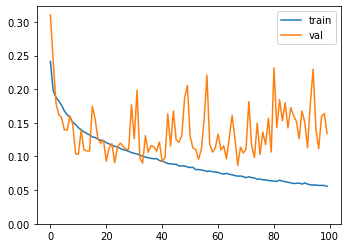

In [12]:
DECODED_LOSS_WEIGHT = 0.5
OUTPUTS_LOSS_WEIGHT = 0.5

mlflow.log_param("decoded loss weight", DECODED_LOSS_WEIGHT)
mlflow.log_param("outputs loss weight", OUTPUTS_LOSS_WEIGHT)

losses = {
    "decoded": "mean_squared_error",
    "outputs": "binary_crossentropy"
}

loss_weights = {
    "decoded": DECODED_LOSS_WEIGHT,
    "outputs": OUTPUTS_LOSS_WEIGHT
}

metrics = {
    "outputs": ["accuracy", precision, recall, f1, fbeta, specificity, npv, mcc]
}
METRIC_TO_MONITOR = "val_outputs_matthews_correlation_coefficient"

outputs_train = {
    "decoded": x_train,
    "outputs": y_train
}

outputs_valid = {
    "decoded": x_val,
    "outputs": y_val
}

model.compile(optimizer='adam', loss=losses, loss_weights=loss_weights, metrics=metrics)

FILE_MODEL = FOLDER_MODELS + timestamp_model_name(prefix="multilearner_")
list_callbacks = [
    ModelCheckpoint(FILE_MODEL, monitor=METRIC_TO_MONITOR, mode="max", verbose=1, save_best_only=True), 
    EarlyStopping(monitor=METRIC_TO_MONITOR, mode="max", patience=30, verbose=1, restore_best_weights=True)
]

hist = model.fit(
    x=x_train,
    y=outputs_train,
    batch_size=32,
    epochs=100,
    validation_data=(x_val, outputs_valid),
    callbacks=list_callbacks
)

plot.keras_hist(hist.history)

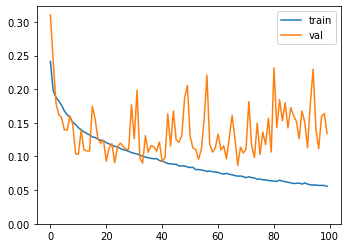

In [14]:
plot.keras_hist(hist.history, metric_train_key='matthews_correlation_coefficient')

[1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 0 1]
[1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 0 1]


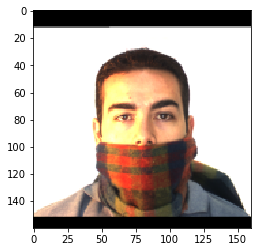

In [62]:
random_idx = np.random.choice(x_val.shape[0])
im = np.expand_dims(x_val[random_idx], axis=0)
y_true = y_val[random_idx] 

y_pred = model.predict(im)[1]
y_pred = np.where(y_pred > 0.5, 1, 0)

print(y_true, y_pred[0], sep='\n')

plt.imshow(im.squeeze()[:, :, ::-1])